In [1]:
%pylab inline
%matplotlib inline

import numpy as np
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as ss
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


In [36]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import normalize
from sklearn.feature_selection import chi2, f_classif
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,classification_report,roc_curve,precision_score
from sklearn.metrics import recall_score, precision_recall_curve, roc_auc_score,f1_score, average_precision_score

# Read in the data file and get an overview on the data set

In [2]:
df = pd.read_csv('SalaryTrainingData.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 7 columns):
Age               32561 non-null int64
workclass         32561 non-null object
education         32561 non-null object
education-num     32561 non-null int64
Race              32561 non-null object
Gender            32561 non-null object
Salary Bracket    32561 non-null object
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


,Age,workclass,education,education-num,Race,Gender,Salary Bracket
0,39,State-gov,Bachelors,13,White,Male,<=50K
1,50,Self-emp-not-inc,Bachelors,13,White,Male,<=50K
2,38,Private,HS-grad,9,White,Male,<=50K
3,53,Private,11th,7,Black,Male,<=50K
4,28,Private,Bachelors,13,Black,Female,<=50K


## Check for missing values

In [3]:
df.isnull().mean()

Age               0.0
workclass         0.0
education         0.0
education-num     0.0
Race              0.0
Gender            0.0
Salary Bracket    0.0
dtype: float64

## There are no missing values in the data but there might be some unknown values. We have two continuous variables 'Age' and 'education-num' which is a numerical variable corresponding to 'education'. Other variables such as 'workclass', 'Race' and 'Gender' are categorical variables. The response variable is 'Salary Bracket'


## Obtain value counts for categorical variables and summary statistics for continuous variables

In [5]:
for col in df.columns:
    if df[col].dtypes == "O":
        print("____________")
        print(df[col].value_counts(normalize = True))

____________
 Private             0.697030
 Self-emp-not-inc    0.078038
 Local-gov           0.064279
 ?                   0.056386
 State-gov           0.039864
 Self-emp-inc        0.034274
 Federal-gov         0.029483
 Without-pay         0.000430
 Never-worked        0.000215
Name: workclass, dtype: float64
____________
 HS-grad         0.322502
 Some-college    0.223918
 Bachelors       0.164461
 Masters         0.052916
 Assoc-voc       0.042443
 11th            0.036086
 Assoc-acdm      0.032769
 10th            0.028654
 7th-8th         0.019840
 Prof-school     0.017690
 9th             0.015786
 12th            0.013298
 Doctorate       0.012684
 5th-6th         0.010227
 1st-4th         0.005160
 Preschool       0.001566
Name: education, dtype: float64
____________
 White                 0.854274
 Black                 0.095943
 Asian-Pac-Islander    0.031909
 Amer-Indian-Eskimo    0.009551
 Other                 0.008323
Name: Race, dtype: float64
____________
 Male      

In [6]:
df.describe()

,Age,education-num
count,32561.000000,32561.000000
mean,38.581647,10.080679
std,13.640433,2.572720
min,17.000000,1.000000
25%,28.000000,9.000000
50%,37.000000,10.000000
75%,48.000000,12.000000
max,90.000000,16.000000


## For 'workclass' and 'education', there are quite a few different classes. We are going to combine some of the small classes together. 

## Generate some plots to see if there are any differences in  salary for difference groups of people.

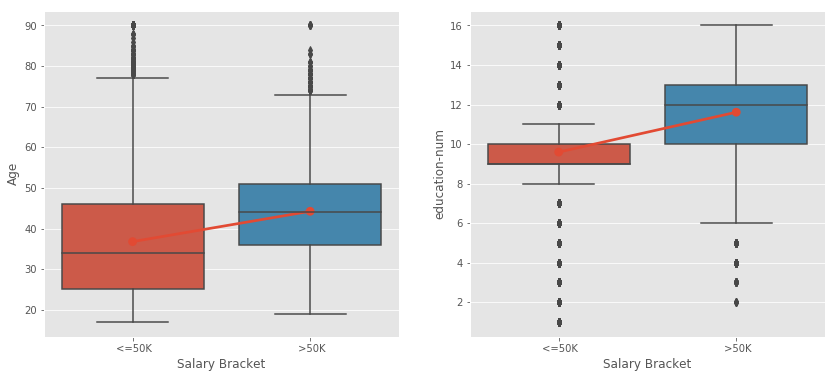

In [7]:
var = ['Age', 'education-num']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
for i,v in enumerate(var):
    
#    sns.boxplot(x='y',y='duration',data=bank,ax=ax[i])
#    sns.pointplot(x='y', y='duration', data=bank.groupby('y', as_index=False).mean(), ax=ax[i])
    sns.boxplot(x='Salary Bracket',y=v,data=df,ax=ax[i])
    sns.pointplot(x='Salary Bracket', y=v, data=df.groupby('Salary Bracket', as_index=False).mean(), ax=ax[i])

## We can see that for people with >50K salary, the age distribution is larger with mean around 45. And also people with higher education have higher salary. Next we are going to look at the categorical variables to see if different people have different percentage to have >50K salary.

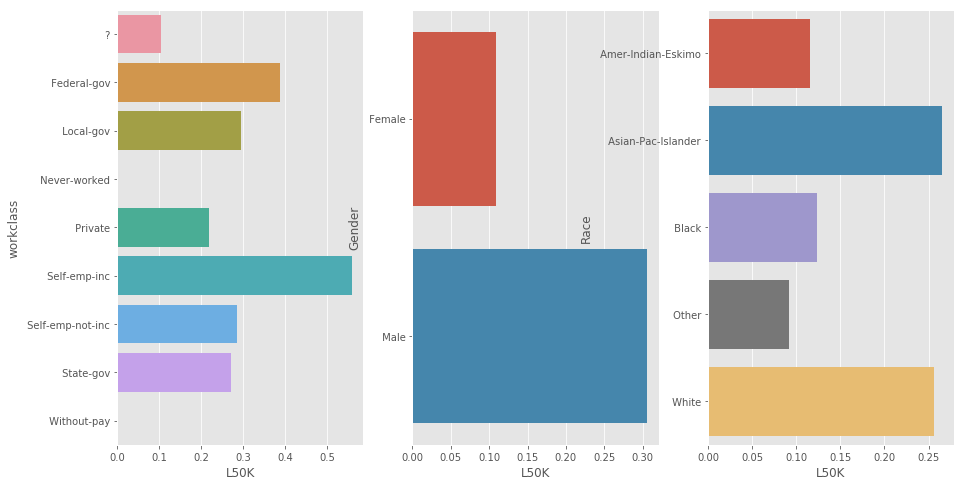

In [14]:
df['L50K'] = [1 if c==' >50K' else 0 for c in df['Salary Bracket']]
fig, ax = plt.subplots(nrows=1,ncols=3,figsize = (15,8))

for i,col in enumerate(['workclass','Gender', 'Race']):
        grouped = df.groupby([col])
        tmp = grouped['L50K'].mean().reset_index()
        sns.barplot(x='L50K',y=col,ci=None,data = tmp,ax=ax[i])

## We can see that 'Self-emp-inc' people have a large percentage of having > 50K salary, although we only have  a small percentage of these people in the data. Also 'Asian-Pac-Islander' and 'White' have a larger percentage of having > 50K salary than other race categories.

In [57]:
var_all = df.columns
X = pd.get_dummies(df,columns=['workclass','Gender','Race','education'])

In [58]:
X.head()

,Age,education-num,Salary Bracket,L50K,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college
0,39,13,<=50K,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,50,13,<=50K,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,38,9,<=50K,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,53,7,<=50K,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,28,13,<=50K,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [59]:
X.columns

Index(['Age', 'education-num', 'Salary Bracket', 'L50K', 'workclass_ ?',
       'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay', 'Gender_ Female',
       'Gender_ Male', 'Race_ Amer-Indian-Eskimo', 'Race_ Asian-Pac-Islander',
       'Race_ Black', 'Race_ Other', 'Race_ White', 'education_ 10th',
       'education_ 11th', 'education_ 12th', 'education_ 1st-4th',
       'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th',
       'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors',
       'education_ Doctorate', 'education_ HS-grad', 'education_ Masters',
       'education_ Preschool', 'education_ Prof-school',
       'education_ Some-college'],
      dtype='object')

## Fit Random Forest to performance variable selection and also to check the performance of the logistic regression. The hyper-parameters were tuned by a grid search.

In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [61]:
# Split the data set into train data and test data
allX = X.drop(['Salary Bracket'],axis=1)
var_select = ['Age', 
       'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay', 'Gender_ Female',
       'Gender_ Male', 'Race_ Amer-Indian-Eskimo', 'Race_ Asian-Pac-Islander',
       'Race_ Black', 'Race_ Other', 'Race_ White', 'education_ 10th',
       'education_ 11th', 'education_ 12th', 'education_ 1st-4th',
       'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th',
       'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors',
       'education_ Doctorate', 'education_ HS-grad', 'education_ Masters',
       'education_ Preschool', 'education_ Prof-school',
       'education_ Some-college']
X = allX.loc[:,var_select]
y = df['L50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
def Model_summary(y, probs, yhat):
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y, probs)
    # calculate AUC
    auc = roc_auc_score(y, probs)
    print('AUC: %.3f' % auc)

    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # show the plot
    pyplot.show()

    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, probs)

    #calculate F1 score
    f1 = f1_score(y, yhat)

    # calculate precision-recall AUC
    #auc = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y, probs)
    # print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
    print('f1=%.3f ap=%.3f' % (f1, ap))
    print(classification_report(y,yhat))
    # plot no skill
    pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(recall, precision, marker='.')
    # show the plot
    pyplot.show()

AUC: 0.811


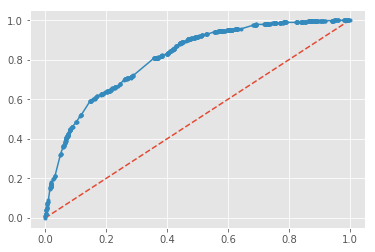

f1=0.538 ap=0.571
              precision    recall  f1-score   support

           0       0.92      0.60      0.72      4942
           1       0.40      0.83      0.54      1571

   micro avg       0.65      0.65      0.65      6513
   macro avg       0.66      0.72      0.63      6513
weighted avg       0.79      0.65      0.68      6513



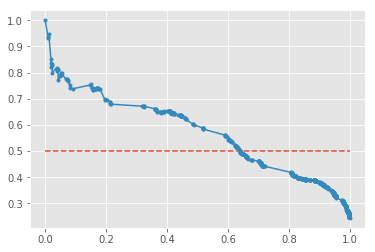

AUC: 0.808


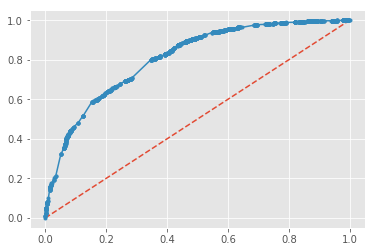

f1=0.539 ap=0.568
              precision    recall  f1-score   support

           0       0.92      0.61      0.73     19778
           1       0.40      0.83      0.54      6270

   micro avg       0.66      0.66      0.66     26048
   macro avg       0.66      0.72      0.63     26048
weighted avg       0.79      0.66      0.68     26048



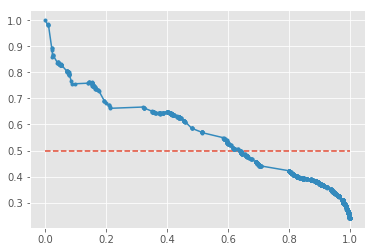

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=0, max_depth = 3, \
                             min_samples_split = 5, min_samples_leaf =5, class_weight='balanced')
clf.fit(X_train, y_train)
y_train_predict_prob = clf.predict_proba(X_train)
y_train_predict = clf.predict(X_train)

y_test_predict_prob = clf.predict_proba(X_test)
y_test_predict = clf.predict(X_test)

Model_summary(y_test, y_test_predict_prob[:,1], y_test_predict)
Model_summary(y_train, y_train_predict_prob[:,1], y_train_predict)

In [64]:
feature_importance = pd.DataFrame(clf.feature_importances_)
feature_importance['name'] = X_train.columns
feature_importance.rename(columns = {0:'importance'}).sort_values(by='importance',ascending=False).head(n=20)

,importance,name
0,0.297723,Age
10,0.137352,Gender_ Male
9,0.109610,Gender_ Female
28,0.095265,education_ Masters
25,0.083431,education_ Bachelors
30,0.081133,education_ Prof-school
27,0.059941,education_ HS-grad
5,0.028010,workclass_ Self-emp-inc
15,0.023824,Race_ White
26,0.019579,education_ Doctorate


## We can see from the feature importance of the model from RandomForest, important variables are very consistent from what we have seen from the charts earlier. I am going to fit a logistic regression model using these variables. Education-num was used as a continuous variable for simplicity. We could try using different education levels as categorical variables as well.

In [66]:
var_select = ['Age','workclass_ Self-emp-inc', 'workclass_ Private', 'Gender_ Male', 'Race_ Asian-Pac-Islander', 'Race_ White', 'education-num']
newX = allX.loc[:,var_select]
newy = df['L50K']

import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(newX)
est = sm.Logit(newy, X2)
est2 = est.fit()
print(est2.summary())

Optimization terminated successfully.
         Current function value: 0.436798
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   L50K   No. Observations:                32561
Model:                          Logit   Df Residuals:                    32553
Method:                           MLE   Df Model:                            7
Date:                Wed, 12 Jun 2019   Pseudo R-squ.:                  0.2087
Time:                        17:00:33   Log-Likelihood:                -14223.
converged:                       True   LL-Null:                       -17974.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -8.3236      0.116    -71.534      0.000      -8.552

## The model above is the one that I selected. The model fit would be better using RandomForest or Gradient boosting. However, logistic regression model offers a simpler model interpretation. We can see that older people have higher salaries. And also people with higher education have higher salary. We can see that 'Self-emp-inc' people have a large percentage of having > 50K salary, although we only have  a small percentage of these people in the data. Also 'Asian-Pac-Islander' and 'White' have a larger percentage of having > 50K salary than other race categories.